## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. Show Camera Calibration Result

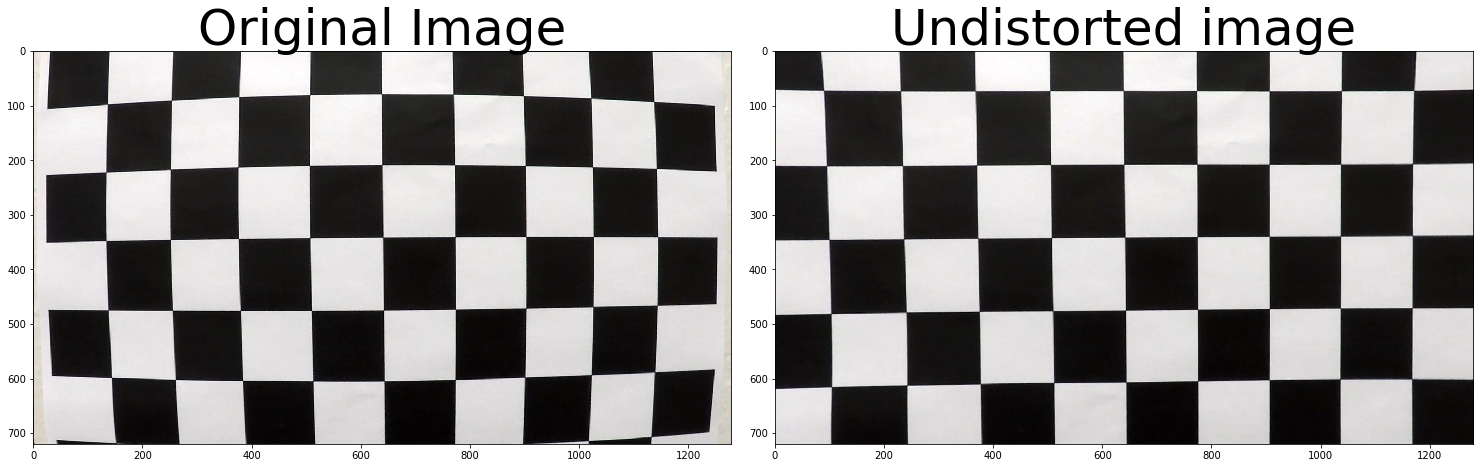

In [2]:
check = mpimg.imread('./camera_cal/calibration1.jpg')

check_undist = cv2.undistort(check, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(check)
ax2.set_title('Undistorted image', fontsize=50)
ax2.imshow(check_undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Save Calibration Parameter as a pickle file

In [3]:
para_pickle = {}
para_pickle['mtx'] = mtx
para_pickle['dist'] = dist
pickle.dump(para_pickle, open('./para_pickle.p', 'wb') )

## 4. Test Lane Finding on one Image

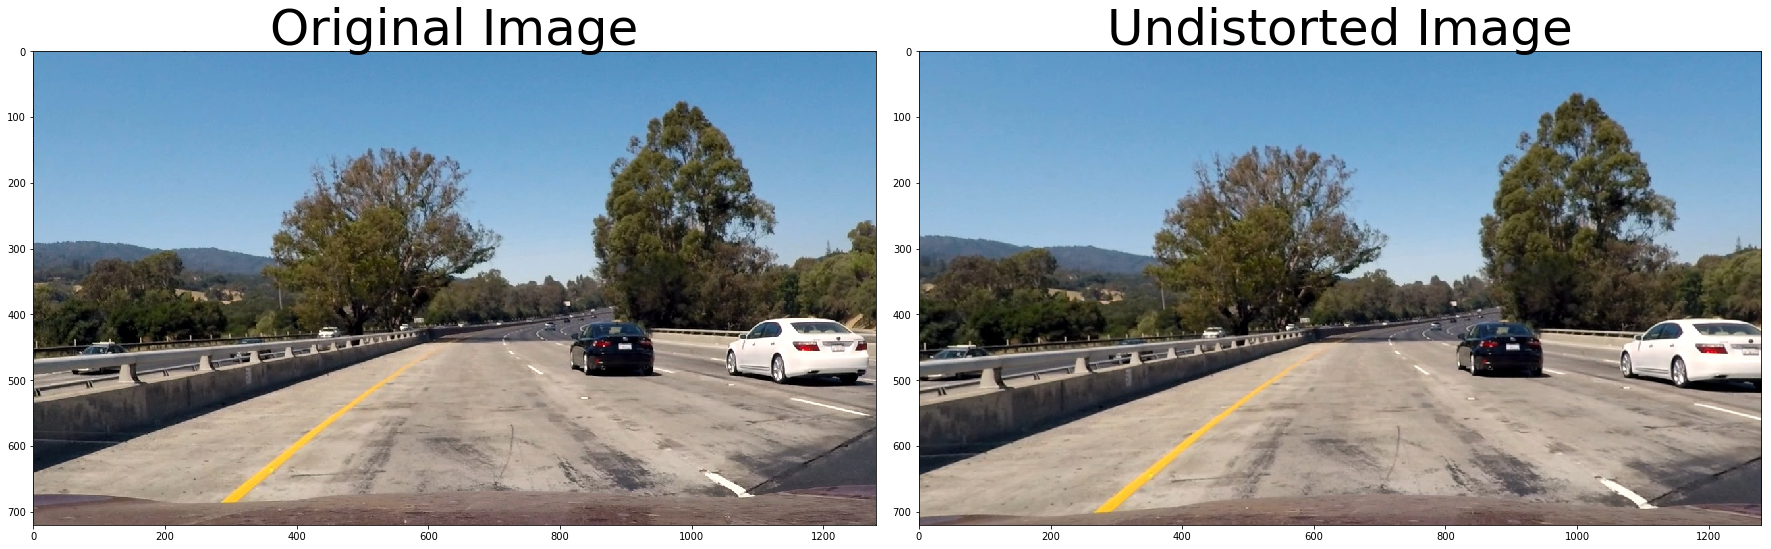

In [4]:
test_img = mpimg.imread('./test_images/test1.jpg')

with open("./para_pickle.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]


test_undist= cv2.undistort(test_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform.

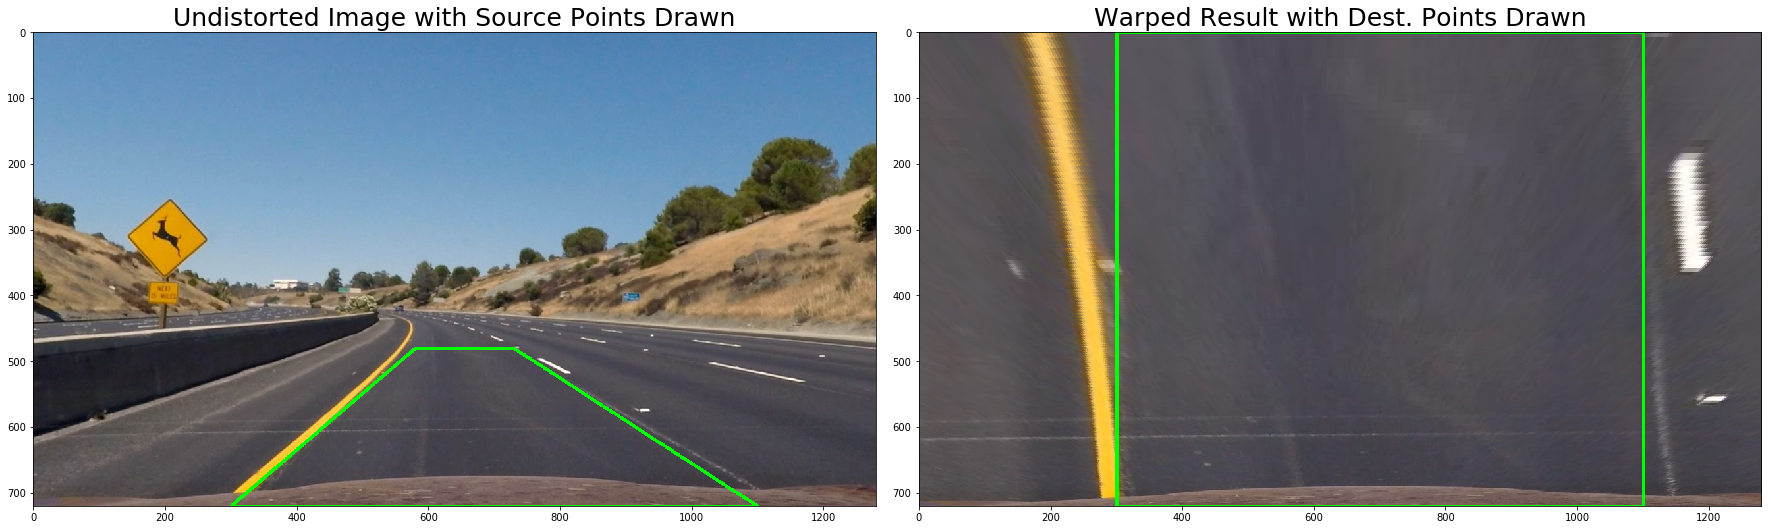

In [5]:
exp = mpimg.imread('./test_images/test2.jpg')

#source points
src = np.float32([[300,720],
                  [1100,720],
                  [730,480],
                  [580,480]])

# object points
dst = np.float32([[300,720],
                  [1100,720],
                  [1100,0],
                  [300,0]])

#undistorted
undist = cv2.undistort(exp, mtx, dist, None, mtx)

#perspective transform
img_size = (undist.shape[1], undist.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_NEAREST)

#visualize undistorted and warped pic with src points and dst points
undist_with_pts = np.copy(undist)
warped_with_pts = np.copy(warped)
cv2.polylines(undist_with_pts, np.int32([src]), True, (0, 255, 0), thickness=4)
cv2.polylines(warped_with_pts, np.int32([dst]), True, (0, 255, 0), thickness=4)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_with_pts)
ax1.set_title('Undistorted Image with Source Points Drawn', fontsize = 25)
ax2.imshow(warped_with_pts)
ax2.set_title('Warped Result with Dest. Points Drawn', fontsize = 25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Binary Image After Sobelx and HLS Threshold

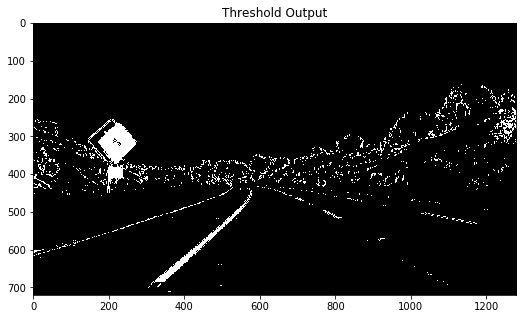

In [6]:
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

# Threshold sobel operator
thresh_min = 40
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(exp, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Threshold color channel
s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


# Stack each channel
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 255
plt.figure(figsize = (12,5))
plt.imshow(combined_binary, cmap='gray')
plt.title('Threshold Output')
plt.show()

## Combined Binary Undistorted Image and Warped Image

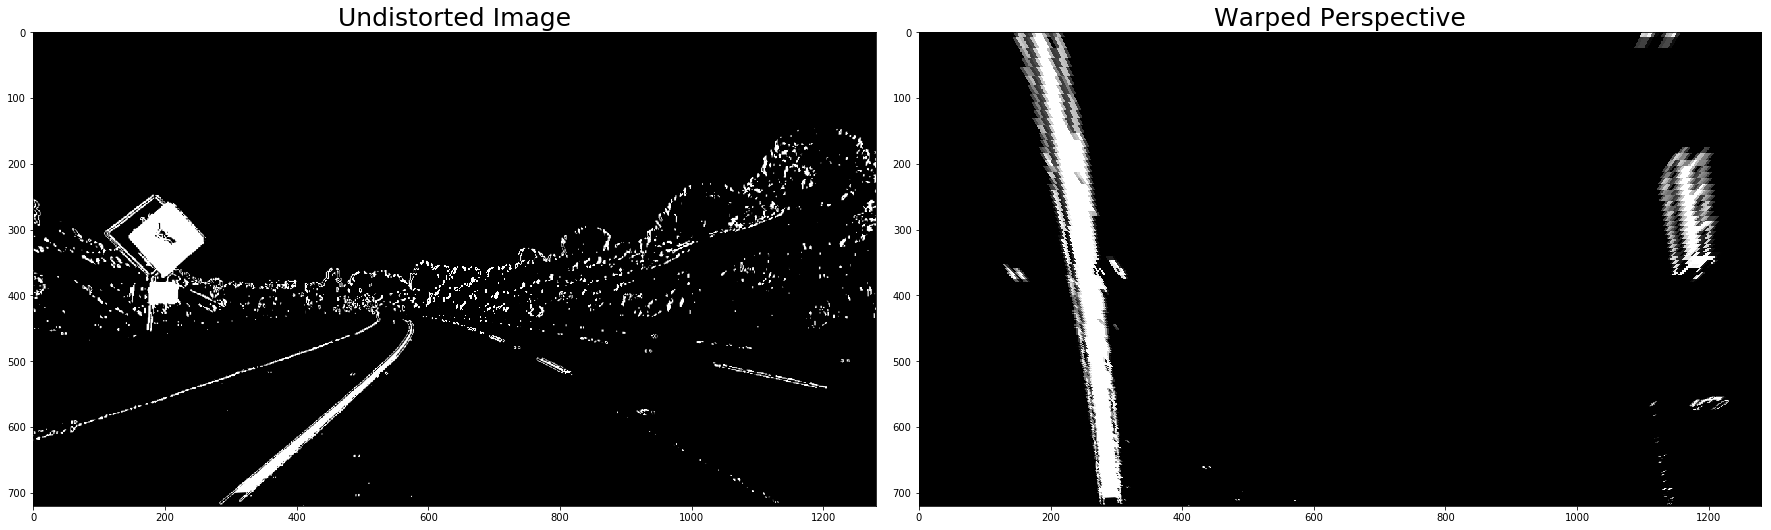

In [7]:
binary_undist = cv2.undistort(combined_binary, mtx, dist, None, mtx)

#perspective transform
img_size = (combined_binary.shape[1], combined_binary.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
binary_warped = cv2.warpPerspective(binary_undist, M, img_size, flags=cv2.INTER_NEAREST)


#visualize undistorted and warped pic with src points and dst points
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_undist, cmap='gray')
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Perspective', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Find Peaks in a Histogram

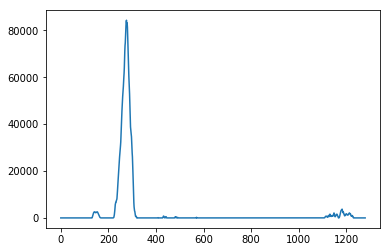

In [8]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.show()
plt.plot(histogram)

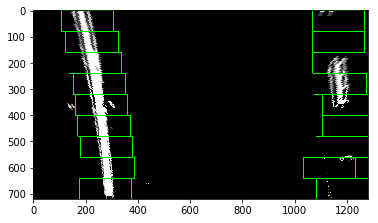

In [9]:
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))


# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

plt.show()
plt.imshow(out_img)

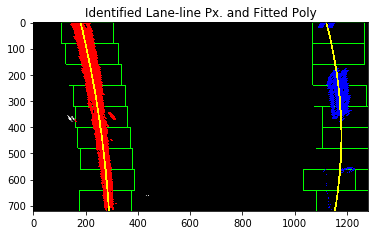

In [10]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

## Plots the left and right polynomials on the lane lines
left_pts = np.transpose(np.vstack((left_fitx, ploty))).astype(np.int32)    
right_pts = np.transpose(np.vstack((right_fitx, ploty))).astype(np.int32)

cv2.polylines(out_img, np.int32([left_pts]), False, (255, 255, 0), thickness=5)
cv2.polylines(out_img, np.int32([right_pts]), False, (255, 255, 0), thickness=5)

plt.show()
plt.title('Identified Lane-line Px. and Fitted Poly')
plt.imshow(out_img)

## Highlight Lane Area

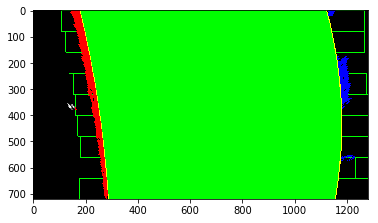

In [11]:
for i in range(binary_warped.shape[0]):
    left = left_fit[0] * i**2 + left_fit[1] * i + left_fit[2]
    right = right_fit[0] * i**2 + right_fit[1] * i + right_fit[2]
    out_img[i][int(left):int(right)] = [0, 255, 0]

plt.show()
plt.imshow(out_img)

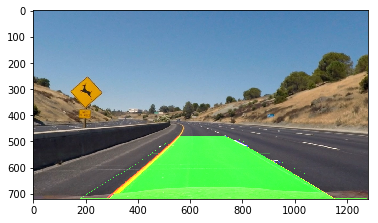

In [12]:
Minv = cv2.getPerspectiveTransform(dst, src)
lane_lines = cv2.warpPerspective(out_img, Minv, (1280, 720), flags=cv2.INTER_LINEAR)
combined_img = cv2.add(lane_lines, undist)
plt.show()
plt.imshow(combined_img)

## Calculate Curvature in Real World

In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Calculation of R_curve (radius of curvature)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
lane_center = (left_fitx[-1]+right_fitx[-1])/2
center_diff = (640-lane_center)*xm_per_pix
curverad = (left_curverad + right_curverad)/2


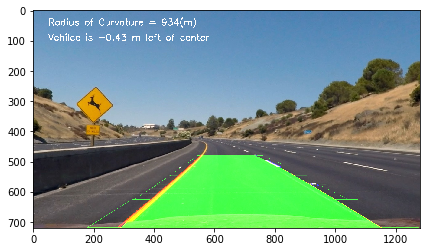

In [14]:
cv2.putText(combined_img, 'Radius of Curvature = %d(m)' % curverad, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
cv2.putText(combined_img, 'Vehilce is %.2f m left of center' % center_diff, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

plt.show()
plt.figure(figsize = (12,4))
plt.imshow(combined_img)

## 5. Build a Lane Finding Pipeline

Define a Lane Class

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

#### Note:
> Automatically determining if your detected lines are the real thing Ok, so your algorithm found some lines, but before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

> * Checking that they have similar curvature
> * Checking that they are separated by approximately the right distance horizontally
> * Checking that they are roughly parallel

Define Image Filter

In [16]:
def img_threshold(undist):
    gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold sobel operator
    sx_thresh_min = 40
    sx_thresh_max = 255 #100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh_min) & (scaled_sobel <= sx_thresh_max)] = 1
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 170 #150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 255
    
    return combined_binary

Define Warper

In [17]:
def warper(undist, M):
    img_size = (undist.shape[1], undist.shape[0])
    warped_undist = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped_undist

Define Sliding Window

In [18]:
def sliding_windows_search(birdeye_binary_undist):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary_undist[birdeye_binary_undist.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary_undist, birdeye_binary_undist, birdeye_binary_undist))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(birdeye_binary_undist.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary_undist.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = birdeye_binary_undist.shape[0] - (window+1)*window_height
        win_y_high = birdeye_binary_undist.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    return left_fit, right_fit, out_img

Define Lane Tracking

In [19]:
def lane_tracking(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!

    binary_warped = img
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
   
    
    return left_fit, right_fit, result    


Define Curverad Calculation

In [20]:
def cal_curverad(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad + right_curverad) / 2
    
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (640 - lane_center) * xm_per_pix
    
    return curverad, center_diff

Define Lane Width In Real World

In [21]:
def lane_quality(ploty, left_fitx, right_fitx):
    
    xm_per_pix = 3.7/700
    
    lane_width = (right_fitx - left_fitx)
    lane_width_mean = np.mean(lane_width)* xm_per_pix
    lane_width_var = np.var(lane_width)
    
    return lane_width_mean, lane_width_var

Define Function Used For Lane Marking

In [22]:
def lane_mask(undist, binary_warped, Minv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

In [23]:
def pipeline(img):
       
    #import parameter
    with open("para_pickle.p", mode='rb') as f:
        camera_calib = pickle.load(f)
    mtx = camera_calib["mtx"]
    dist = camera_calib["dist"]
    
    #source points
    src = np.float32([[300,720],
                      [1100,720],
                      [730,480],
                      [580,480]])
    
    # object points
    dst = np.float32([[300,720],
                      [1100,720],
                      [1100,0],
                      [300,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    #undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #generate undistorted binary image
    binary_undist = img_threshold(undist)
    
    #bird-eye image ---binary and colored
    birdeye_binary_undist = warper(binary_undist, M)
    birdeye_binary_colored = warper(undist, M)
    
    #decide --- to run a sliding windows search or keep the lane in the front image
    if (not line_l.detected) or (not line_r.detected):
        # Run a sliding windows search
        left_fit, right_fit, img_search = sliding_windows_search(birdeye_binary_undist)
        cv2.putText(img_search, 'Searching', (550, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
        
    else:
        
        left_fit, right_fit, img_search = lane_tracking(birdeye_binary_undist, line_l.recent_xfitted[-1][0], line_r.recent_xfitted[-1][0]) 
        cv2.putText(img_search, 'Tracking', (550, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
    
    line_l.current_fit = [left_fit]
    line_r.current_fit = [right_fit]
    
    line_l.bestx = None
    line_r.bestx = None
    
    line_l.recent_xfitted.append([left_fit])
    line_r.recent_xfitted.append([right_fit])
    
    if len(line_l.recent_xfitted)>1:
        line_l.best_fit = np.mean(np.array(line_l.recent_xfitted[-20:-1]), axis=0) 
        line_r.best_fit = np.mean(np.array(line_r.recent_xfitted[-20:-1]), axis=0)    
    
    else:
        line_l.best_fit = line_l.recent_xfitted[-1][0]
        line_r.best_fit = line_r.recent_xfitted[-1][0] 
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_width_mean, lane_width_var = lane_quality(ploty, left_fitx, right_fitx)
    
    #check if new polynomial parameters are fit enough
    if (not 3 < lane_width_mean < 5) or (lane_width_var > 500):
        
        line_l.detected = False
        line_r.detected = False
        
        del line_l.recent_xfitted[-1]
        del line_r.recent_xfitted[-1]
        
        left_fit, right_fit = line_l.best_fit[0], line_r.best_fit[0]
        
        cv2.putText(img_search, '------', (550, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 5)
        
        cv2.putText(img_search, 'Keeping', (550, 450), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)        
        
    else:
        
        line_l.detected = True
        line_r.detected = True

        line_l.best_fit = np.mean(np.array(line_l.recent_xfitted[-20:]), axis=0) 
        line_r.best_fit = np.mean(np.array(line_r.recent_xfitted[-20:]), axis=0)
    
    # Calculate the curverad by appropriate polynomial parameters
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    curverad, center_diff = cal_curverad(ploty, left_fitx, right_fitx)
    
    result = lane_mask(undist, birdeye_binary_undist, Minv, ploty, left_fitx, right_fitx)
    
    cv2.putText(result, 'Radius of Curvature = '+str(round(curverad, 1))+'(m)',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is '+str(round(center_diff, 2))+'(m) off center', (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    canvas = np.zeros([960,1280,3], dtype=np.uint8)
    
    canvas[0:720, 0:1280, :] = result
    
    img_debug = binary_undist
    color_debug = np.dstack(( img_debug, img_debug, img_debug ))
    cv2.polylines(color_debug, np.int32([src]), True, (0, 255, 0), thickness=4)
    plot1 = cv2.resize(color_debug, (426, 240))
    
    ## Plot 2: bird eye view (color)
    cv2.polylines(birdeye_binary_colored, np.int32([dst]), True, (0, 255, 0), thickness=4)
    plot2 = cv2.resize(birdeye_binary_colored, (426, 240))
    
    ## Plot 4: the searching process
    plot4 = img_search
    left_pts = np.transpose(np.vstack((left_fitx, ploty))).astype(np.int32)    
    right_pts = np.transpose(np.vstack((right_fitx, ploty))).astype(np.int32)

    cv2.polylines(plot4, np.int32([left_pts]), False, (255, 255, 0), thickness=5)
    cv2.polylines(plot4, np.int32([right_pts]), False, (255, 255, 0), thickness=5)
    plot4 = cv2.resize(img_search, (426, 240))
    
    canvas[720:960, 0:426, :] = plot1
    canvas[720:960, 427:427+426, :] = plot2
    canvas[720:960, -427:-1, :] = plot4
    
    
    return canvas

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_l = Line()
line_r = Line()
output = 'project_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [05:11<00:00,  3.98it/s]


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))